# AI Project A*

Trabalho realizado por:
    - Tiago Matos 21905643
    - Paulo Pinto 21906966

### IMPORTS

- matplotlib e seaborn -> desenhar gráficos e heatmap
- imageio -> criar gif da solução
- pandas -> dataframe para representar dados em gráficos
- numpy -> array para guardar o mapa
- shutil, os -> gestão de ficheiros e directories (apagar `/output/`)
- time -> obter a unix timestamp. medir perfomance de funções
- math -> operações matemáticas como floor() ou sqrt()

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import imageio.v2 as imageio

import pandas as pd
import numpy as np

import shutil
import os

import time
import math


plt.ioff()

GLOBAL VARIABLES

In [21]:
START = 'S'  # Start -> nó inicial (canto superior esquerdo)
END = 'E'  # End -> nó final (canto inferior direito)
TERRA = 'T'  # Terra -> movimento para este nó tem custo 1
AGUA = 'A'  # Agua -> movimento para este nó tem custo 3
BARREIRA = 'B'  # Barreira -> can't move here
FRONTEIRA = 'F'  # Fronteira -> can't move here

In [22]:
CSV_ENV_FILE = 'input/sample-environment.csv' # example-environment.csv mapa 25x25
DISPLAY_INTERVAL = 25 # iterations of interval between showing map 

CLASSES

In [23]:
class Node:
    def __init__(self, name, pos, cost_so_far, heuristic, path):
        self.name = name
        self.pos = pos
        self.cost_so_far = cost_so_far
        self.heuristic = heuristic
        self.path = path
        self.visited = False
        self.done = False
    
    def __str__(self):
        return f'{self.name} | {self.pos} | {self.cost_so_far} | {self.heuristic} | {self.combined_cost}\n{self.path}'

    def simple_print(self):
        return f'{self.name} - {self.pos} - {self.combined_cost}\n{self.path}'
    
    def __eq__(self, obj):
        return obj.name == self.name and obj.pos == self.pos
    
    @property
    def combined_cost(self):
        return self.cost_so_far + self.heuristic

In [38]:
class NodeStructures:
    def __init__(self, start_node, grid):
        self.counter = 0
        self.done = []
        self.q = [start_node]
        self.node_map = {start_node: Node(grid[0][0], start_node, 0, 0, [start_node])}
        self.initialize_nodes(start_node, grid)

    def initialize_nodes(self, start_node, grid):
        for (y, line) in enumerate(grid):
            for (x, _) in enumerate(line):
                if (x, y) != start_node:
                    heuristic = calculate_heuristic_distance(x, y, *GOAL)
                    self.node_map[(x, y)] = Node(grid[x][y], (x, y), 9999, heuristic, [])

    def get_node_from_queue(self, pos):
        return self.node_map[pos]

    def get_graph_map_list(self, path=[]):
        map = [[''] * (MAP_SIZE + 1) for _ in range(MAP_SIZE + 1)]
        for pos in self.node_map:
            if pos in path:
                map[pos[0]][pos[1]] = 'P'
            elif self.node_map[pos].done:
                map[pos[0]][pos[1]] = 'D'
            elif self.node_map[pos].visited:
                map[pos[0]][pos[1]] = 'V'
            else:
                map[pos[0]][pos[1]] = self.node_map[pos].name
        map[MAP_SIZE][MAP_SIZE] = 'E'
        return map

In [36]:
def read_file(file_name):
    """Retorna um array (formatado) com os dados do ficheiro escolhido"""
    with open(file_name) as fp:
        fp.readline() # ignore first line
        for l in fp.readlines():
            yield l.strip("\n").split(',')[1:]

# Heuristic

Foi escolhida a função nr 2 porque foi a que funcionou

In [37]:
# crashes
def calculate_heuristic_distance(x,y, final_x, final_y):
    dx = abs(x - final_x)
    dy = abs(y - final_y)
    return min(dx, dy)

def calculate_heuristic_distance_2(x,y, final_x, final_y):
    dx = abs(x - final_x)
    dy = abs(y - final_y)
    md = 1 # move distance
    md2 = 2 # move distance 2
    return md * (dx + dy) + (md2 - 2 * md) * min(dx, dy)

# crashes
def calculate_heuristic_distance_3(x,y, final_x, final_y):
    dx = abs(x - final_x)
    dy = abs(y - final_y)
    return 1 * math.sqrt(dx * dx + dy * dy)

In [27]:
def get_next_moves(x,y):
    return [(x - 1, y - 1), (x - 1, y), (x - 1, y + 1),
            (x, y - 1),                     (x, y + 1),
            (x + 1, y - 1), (x + 1, y), (x + 1, y + 1),]

# Visualização

`visualize_env` usa a biblioteca seaborn para mostrar o estado atual do mapa, incluíndo o caminho

`print_final_path` mostra o caminho que for introduzido e calcula o seu custo, é usado para mostrar o caminho no final


In [28]:
def visualize_env(map, file_name):
    map_envir = pd.DataFrame(map)
    map_env_num = map_envir.replace(['T', 'A', 'F', 'B', 'S', 'E', 'V', 'D', 'P', 'SP'], [
                                      2,   3,   0,   0,   1,   1,   4,   5,   6,   6])
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(map_env_num, cmap="mako")
    f.savefig(f'output/{file_name}.png')

def print_final_path(final_path):
    """
    Mostra o caminho final e calcula o seu custo
    """
    lines_info = list(read_file(CSV_ENV_FILE))
    grid = np.array(lines_info, dtype=object)
    cost = 0
    for x,y in final_path:
        cost += 3 if grid[x][y] == "A" else 1
        grid[x][y] = 'V'
    print(f"final path's length is {len(final_path)} - costs {cost}")
    visualize_env(grid, 'path')

# A*

Optámos por criar classes para os nós e para as estruturas de dados
 

In [30]:
def a_star_algo(node_structures, goal, visualize = False):
    """
    Realiza o algoritmo A*, recursivamente.

    Parameters
    ----------
    node_structures : NodeStructures
        Estruturas auxiliares (queue, visited, etc...)
    goal : tuple (int, int)
        Nó final
    visualize : bool, default: False
        Define se gráficos e gif são criados e mostrados
    """
    node_map = node_structures.node_map
    q = node_structures.q
    
    node_structures.counter += 1
    if visualize:
        if node_structures.counter % DISPLAY_INTERVAL == 0:
            # print(int(node_structures.counter / DISPLAY_INTERVAL))
            visualize_env(node_structures.get_graph_map_list(),
                        f'map_stage_{int(node_structures.counter / DISPLAY_INTERVAL):0>2}')
            # timestamp -> math.floor(time.time())

    h = q.pop(0)
    node_map[h].done = True

    if h == goal:
        print("END GOAL REACHED")
        if visualize:
            visualize_env(node_structures.get_graph_map_list(
                node_map[h].path), 'map_stage_final')
        print_final_path(node_map[h].path)
        return
    
    for x, y in get_next_moves(*h):
        # if move goes outside of map, skip
        if not 0 < x <= MAP_SIZE or not 0 < y <= MAP_SIZE:
            continue

        node = node_map[(x,y)]
        
        if node.name not in [FRONTEIRA, BARREIRA] and not node.done:
            # check cost of valid nodes
            if node.cost_so_far > (new_cost := node_map[h].cost_so_far + (3 if node.name == AGUA else 1)):
                # change cost and path if new path is better
                node.cost_so_far = new_cost
                node.path = node_map[h].path + [node.pos]
            if not node.visited:
                # mark as visited
                q.append(node.pos)
                node.visited = True

    node_structures.q = list(set(q)) # remove duplicates
    node_structures.q.sort(key=lambda x: node_map[x].combined_cost)
    a_star_algo(node_structures, goal, visualize)

END GOAL REACHED


C:\Users\ppdig\AppData\Local\Temp\ipykernel_8244\416760131.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(16, 10))


final path's length is 37 - costs 37


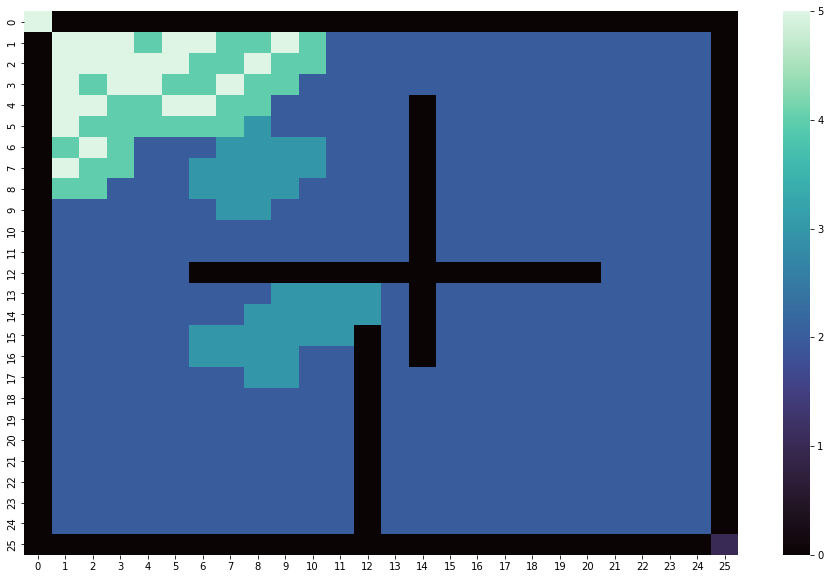

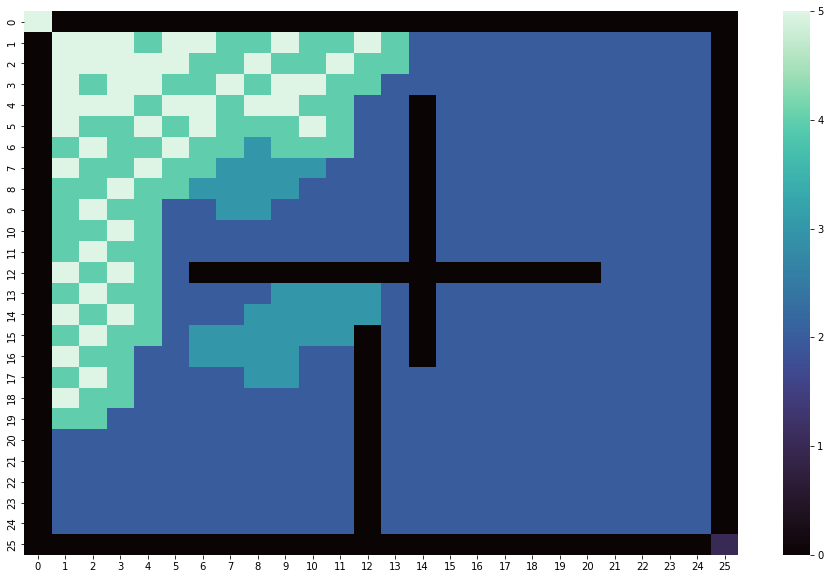

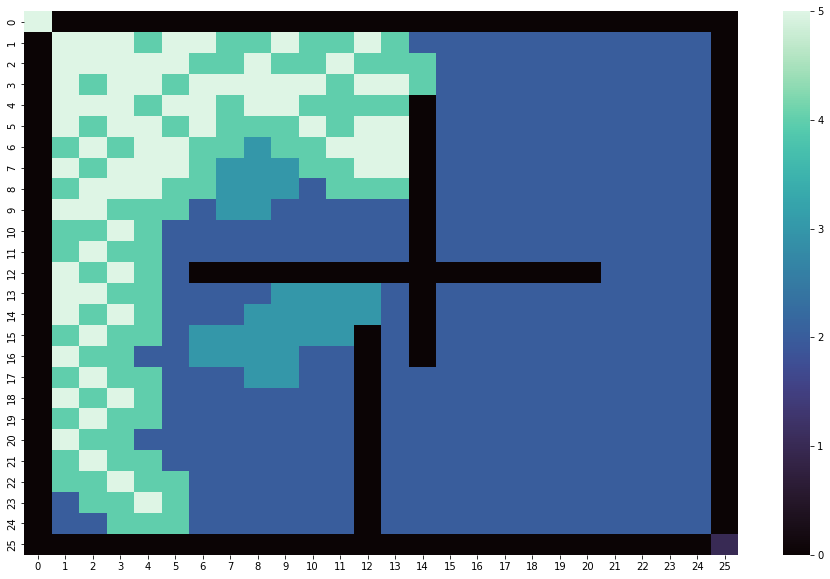

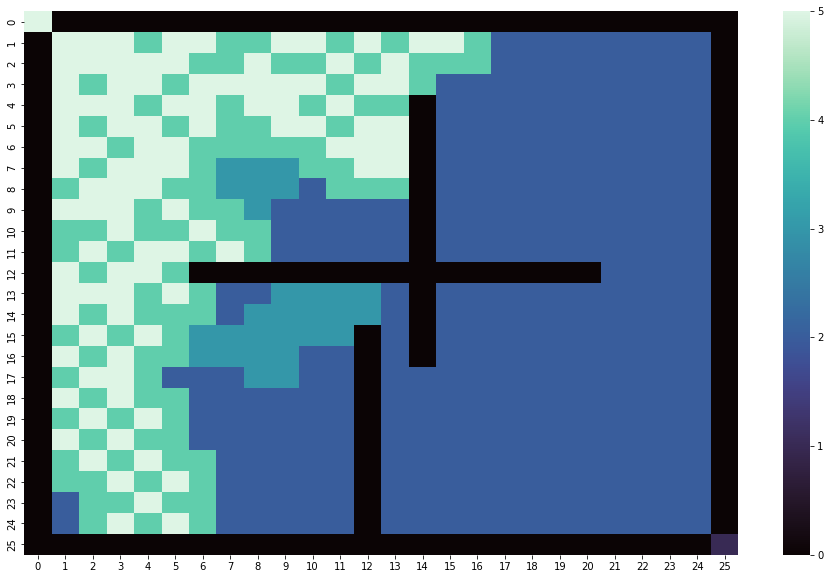

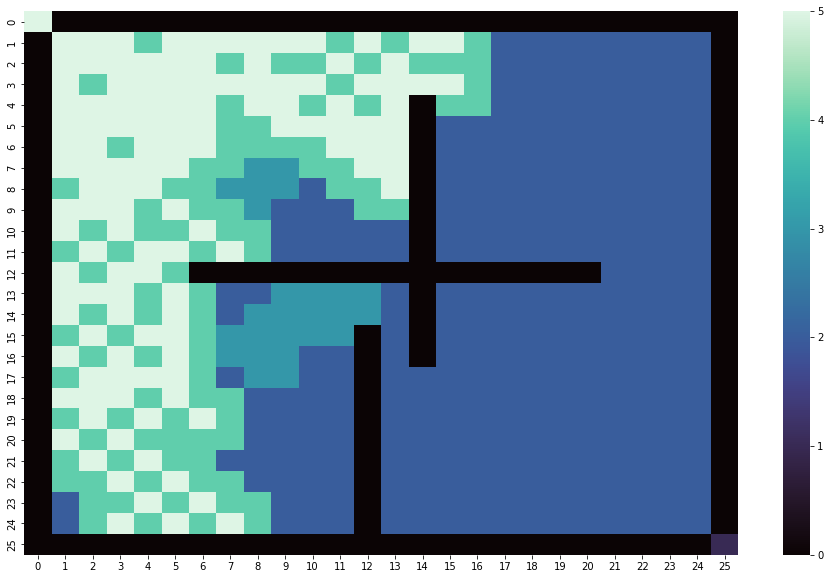

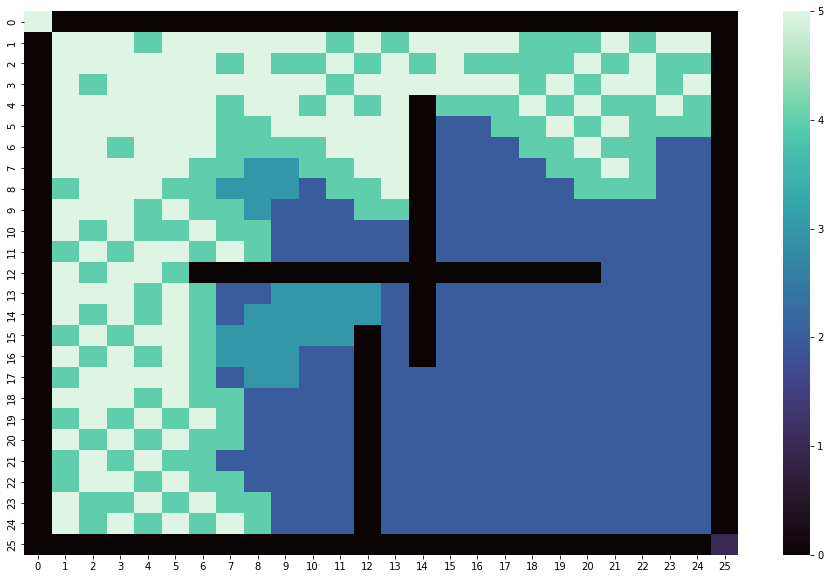

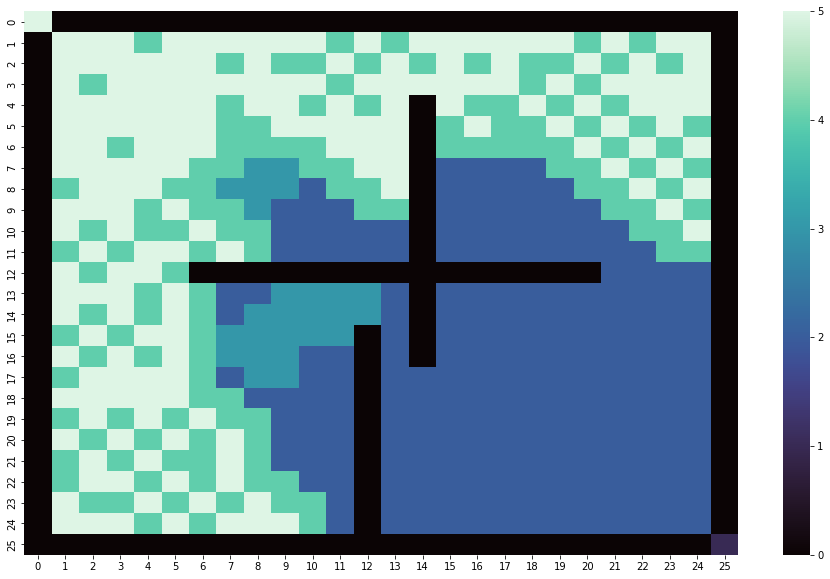

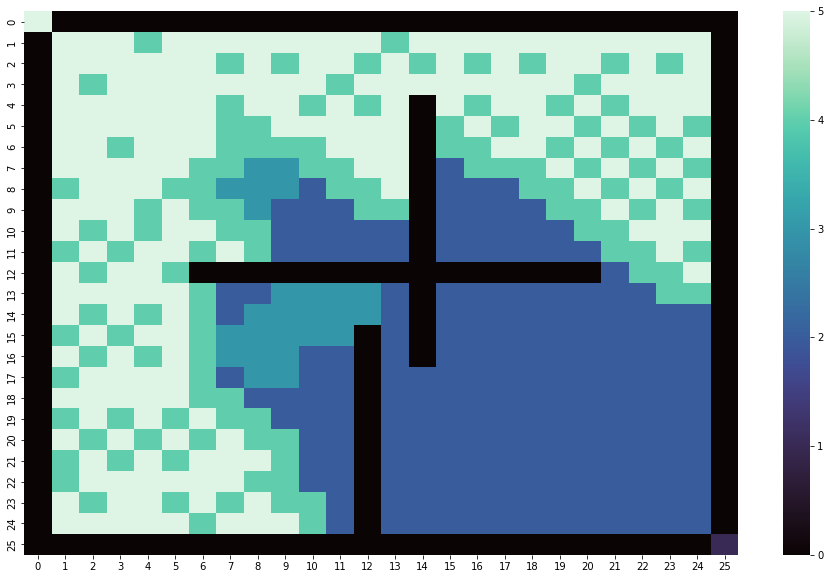

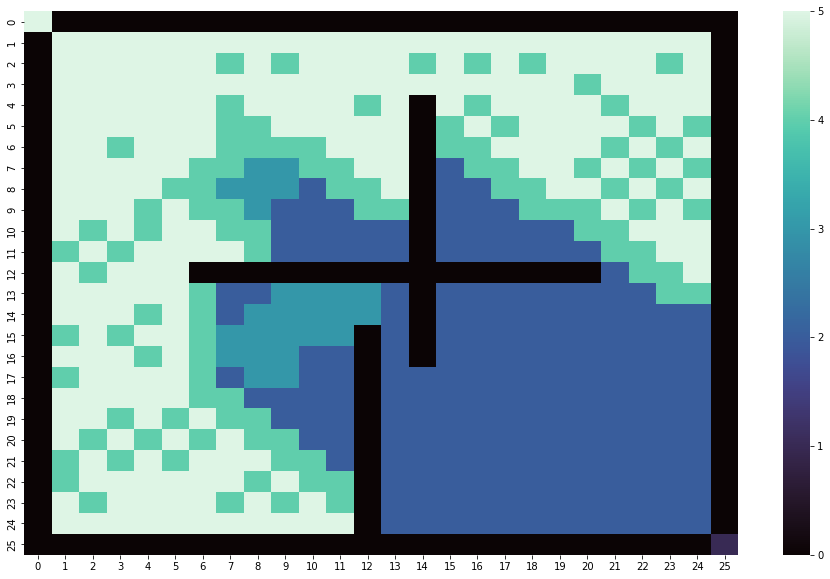

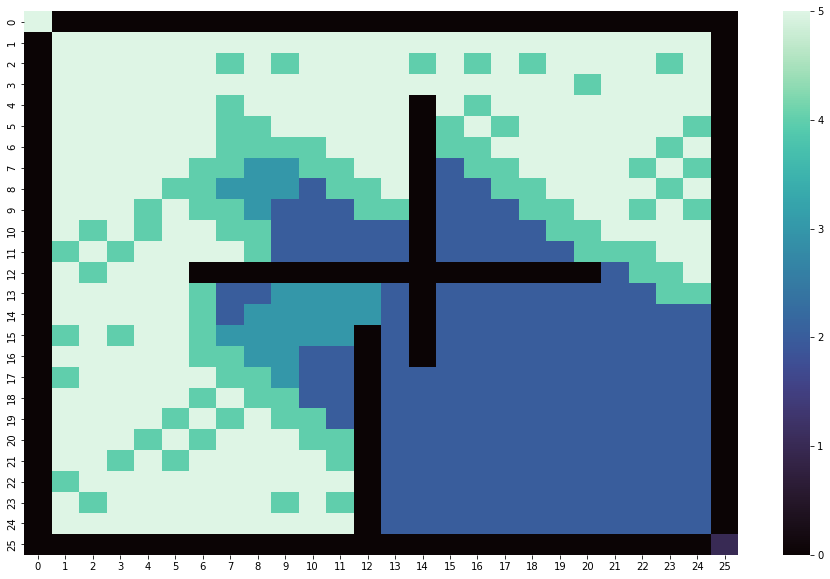

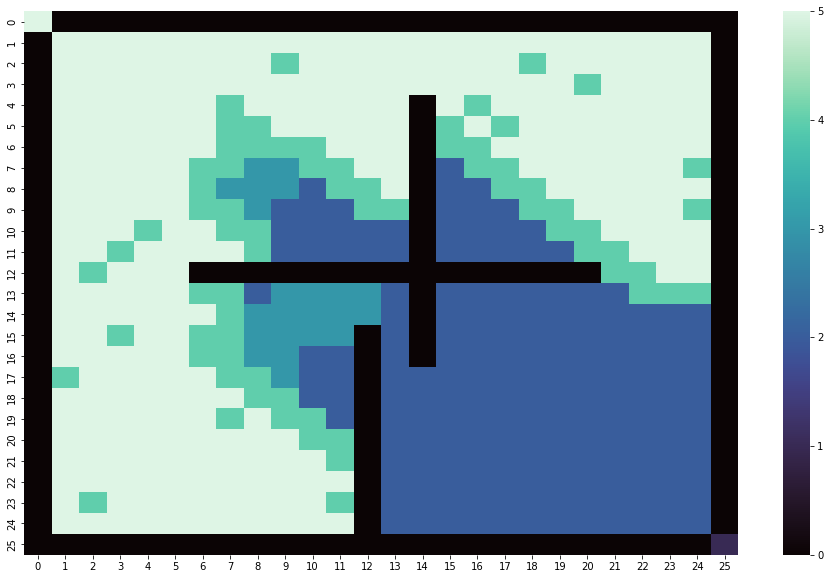

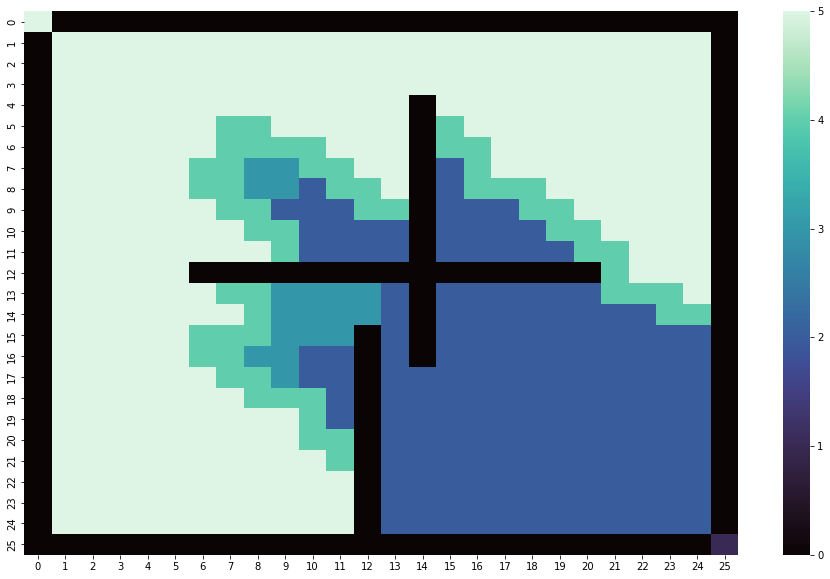

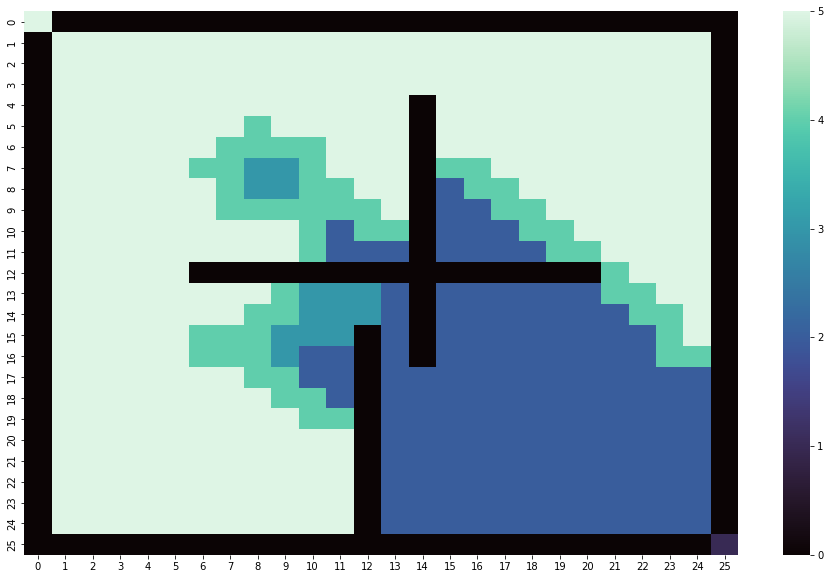

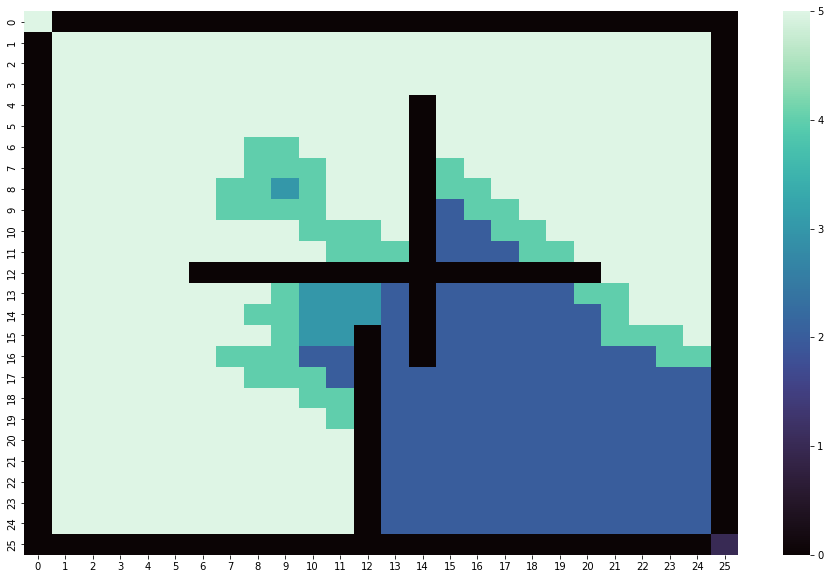

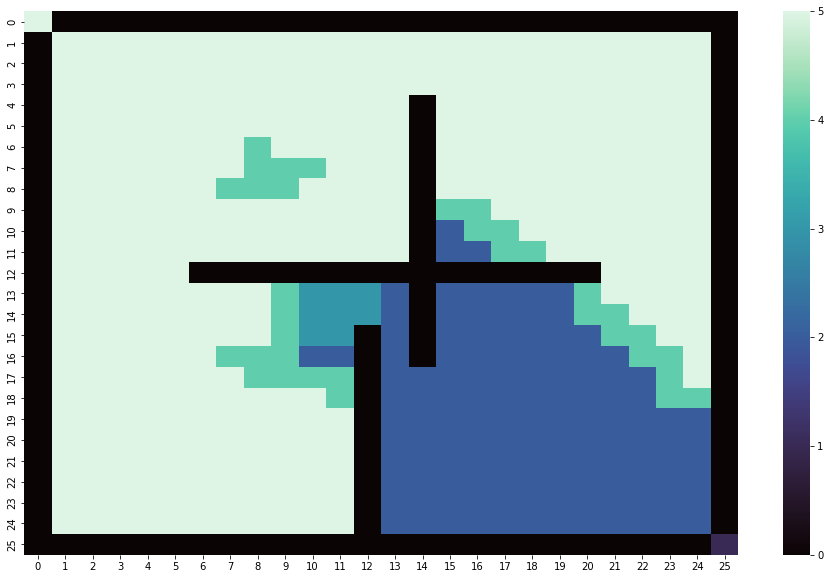

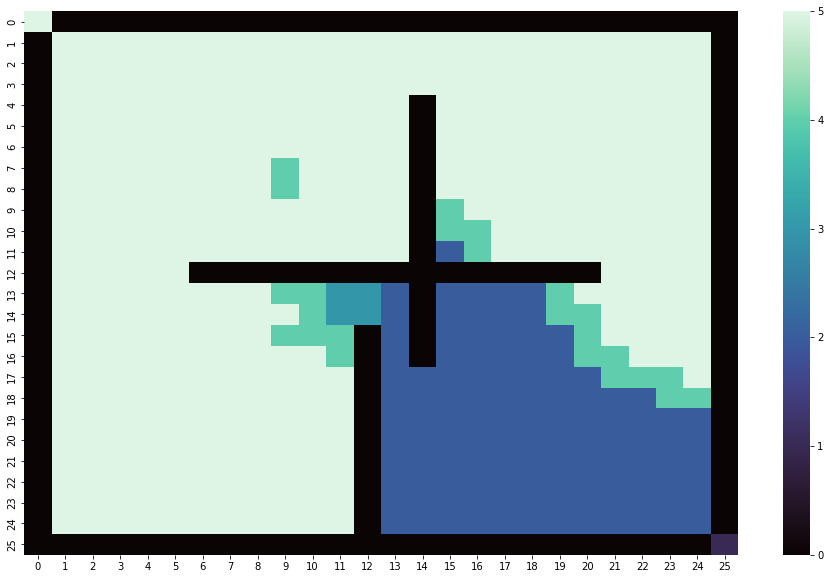

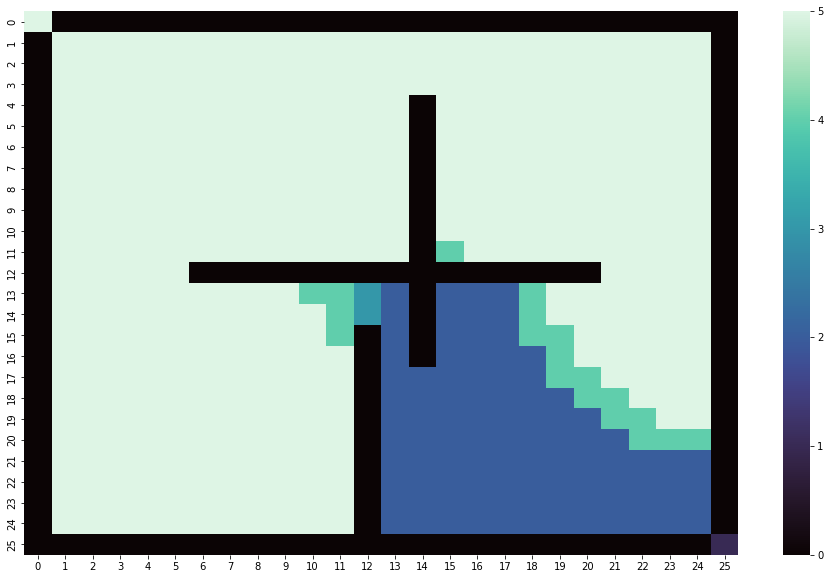

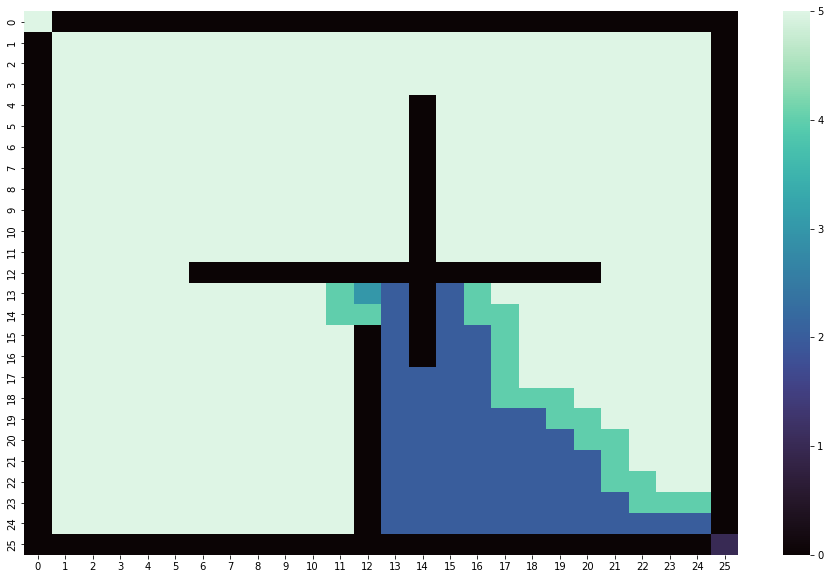

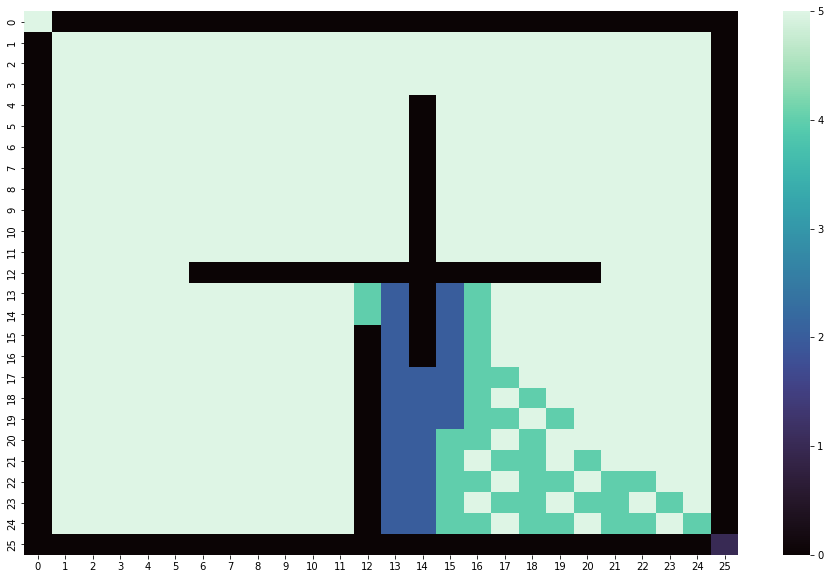

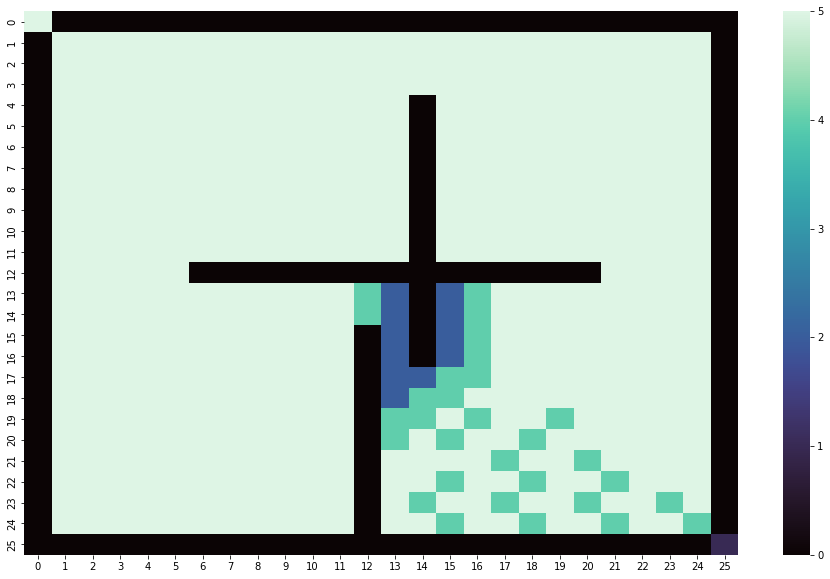

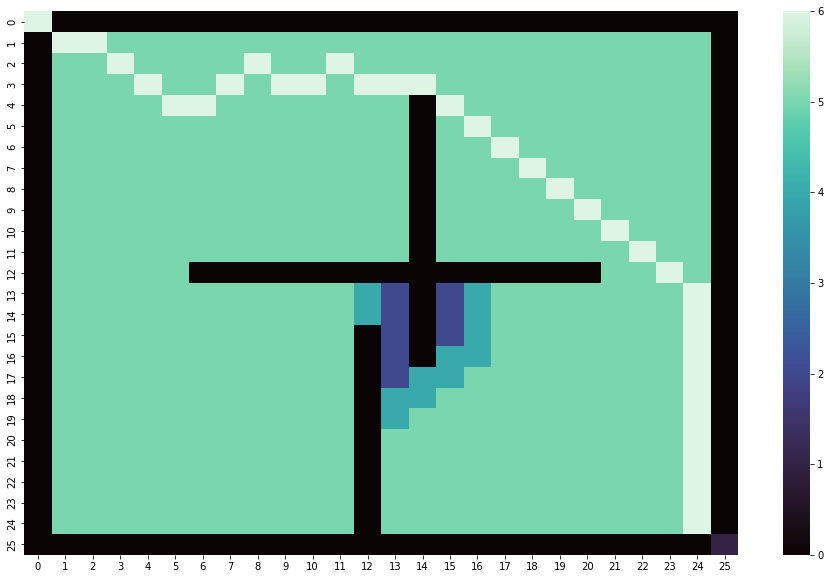

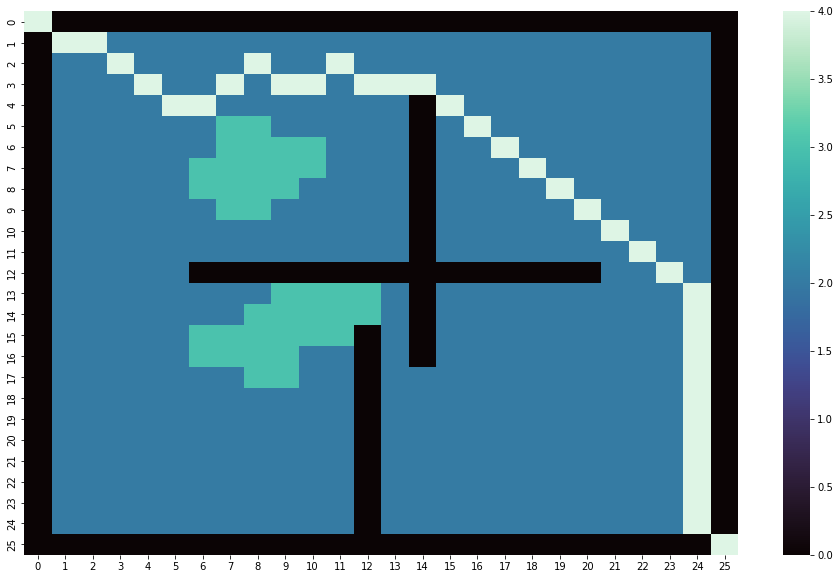

In [39]:

lines_info = list(read_file(CSV_ENV_FILE))
grid = np.array(lines_info, dtype=object)

MAP_SIZE = len(lines_info[0]) - 1
START = (0, 0)
GOAL = (MAP_SIZE, MAP_SIZE)

node_structures = NodeStructures(START, grid)

shutil.rmtree('output')
os.makedirs('output')

a_star_algo(node_structures, GOAL, visualize = True)

Criar GIF com a resolução.

In [35]:
images = []

dir = os.listdir("output")

for filename in dir:
    f = os.getcwd() + "\\output\\" + filename
    # don't show path
    if "path.png" in f:
        continue
    # show final map for longer
    if "map_stage_final.png" in f:
        for _ in range(20):
            images.append(imageio.imread(f))
    
    images.append(imageio.imread(f))

if images:
    imageio.mimsave(os.getcwd() + '\\solves\\solve.gif', images, duration=0.15)
else:
    print("No images were generated, can't create gif")

black Projeto.ipynb -l 94